In [1]:
import numpy as np
import pandas as pd

Im trying to see how cardinality affects total variation distance for two random probabilities on finite sets

# Totally random case
where $\alpha = 1$

We define $p_1 \sim Dirichlet((1, ..., 1))$ and $p_2 \sim Dirichlet((1, ..., 1))$ and then compute $TV(p_1, p_2)$ to get some statistics

In [73]:
def calc_tv(p1, p2):
    return abs(p1 - p2).sum(axis=1)

def sample_two_dir(card, samples):
    return np.random.dirichlet(np.ones(card), size=(2, samples))

def sample_tv(card, samples, kind='uniform'):
    if kind == "uniform":
        dir_samples = np.random.dirichlet(np.ones(card), size=(2, samples))
    else:
        pass
    p1, p2 = dir_samples[0], dir_samples[1]
    tv = calc_tv(p1, p2)
    return tv

def estimate_prob(card, thresh, kind='uniform'):
    tv_samples = sample_tv(card, samples, kind)
    return (tv_samples >= thresh).mean()

def estimate_mean(card, kind='uniform'):
    tv_samples = sample_tv(card, samples, kind)
    return tv_samples.mean() 

In [92]:
card_range = np.arange(2, 100, dtype=int)
samples = 1_000_000
thresh = 1.5

prob_series = pd.Series({card: estimate_prob(card, thresh) for card in card_range}, 
                        name=f'prob(tv > {thresh})')
mean_series = pd.Series({card: estimate_mean(card) for card in card_range},
                        name='E(tv)')

<AxesSubplot:>

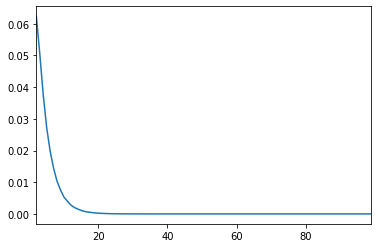

In [93]:
prob_series.plot()

<AxesSubplot:>

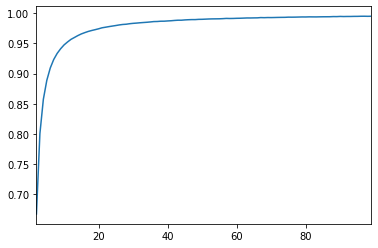

In [94]:
mean_series.plot()